# 10-02 Neural Graph Embedding with DeepWalk

*June 26 2024*  

In [17]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch import autograd
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from sklearn.decomposition import TruncatedSVD

plt.style.use('default')
sns.set_style("whitegrid")

import pathpyG as pp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pp.config['torch']['device'] = device
print('Running on', pp.config['torch']['device'])

Running on cuda


We will now provide a simple from-scratch implementation of DeepWalk. We first need a network.

In [2]:
edges = [
    ('a', 'b'),
    ('b', 'c'),
    ('a', 'c'),
    ('b', 'd'),
    ('d', 'f'),
    ('d', 'g'),
    ('d', 'e'),
    ('e', 'f'),
    ('f', 'g')
]

n = pp.Graph.from_edge_list(edges)
n = n.to_undirected()

In [3]:
pp.plot(n)

We now simulate random walks. It is easy to do this using the `RandomWalk` class of the `pathpy.processes` module. We first initialize a random walk process on the network. This generates the transition matrix as well as the alias tables for the alias sampling method.

In [4]:
rw = pp.processes.RandomWalk(n)
rw.transition_matrix_pd()

,a,b,c,d,e,f,g
a,0.000000,0.50,0.500000,0.000000,0.000000,0.00,0.000000
b,0.333333,0.00,0.333333,0.333333,0.000000,0.00,0.000000
c,0.500000,0.50,0.000000,0.000000,0.000000,0.00,0.000000
d,0.000000,0.25,0.000000,0.000000,0.250000,0.25,0.250000
e,0.000000,0.00,0.000000,0.500000,0.000000,0.50,0.000000
f,0.000000,0.00,0.000000,0.333333,0.333333,0.00,0.333333
g,0.000000,0.00,0.000000,0.500000,0.000000,0.50,0.000000


We can now simulate a number of random walks with given length $l$. Here we start a total of 100 random walks at random nodes, each walker walking for exactly 5 steps. This function returns a data frame that contains the trajectory of the random walk process. We can then use the `get_paths` function to extract the sequences of traversed nodes and we can add those sequences to a single list:

In [5]:
data = rw.run_experiment(runs=100, steps=5)
walks = rw.get_paths(data)

100%|██████████| 100/100 [00:00<00:00, 8544.28it/s]


In [6]:
walks = [walks.get_walk(i) for i in range(walks.num_paths)]

In [7]:
# rw.plot(data, edge_color='gray')

You see that we get the same data structure as in the previous notebook, i.e. here we have a list of walks, where each walk consists of a sequence of traversed nodes that we seek to embed. In the previous notebook, we have considered a list of sentences, where each sentence was a sequence of words that we wanted to embed. Treating nodes as words and walks as sentences, we can thus reuse the functions from the previous notebook:

In [31]:
def build_vocabulary(tokens):
    vocab = []
    for sentence in tokens:
        for word in sentence:
            if word not in vocab:
                vocab.append(word)
    return vocab

def build_word_context_pairs(tokens, window_size):
    pairs = []
    for sentence in tokens:
        for center in range(len(sentence)):
            for i in range(-window_size, window_size+1):
                context_word = center + i
                if context_word < 0 or context_word >= len(sentence) or center == context_word:
                    continue
                pairs.append((sentence[center], sentence[context_word]))
    return pairs

def get_ohe(word, vocab):
    word_idx = vocab.index(word)
    x = torch.zeros(1,len(vocab)).float()
    x[:,word_idx] = 1.0
    return x.to(device)

Our vocabulary consists of the nodes in the network, and we can apply one-hot-encoding to represent each node:

In [12]:
vocab = build_vocabulary(walks)
print(vocab)

['d', 'b', 'g', 'f', 'e', 'c', 'a']


In [13]:
get_ohe('f', vocab)

tensor([[0., 0., 0., 1., 0., 0., 0.]])

We can now build the node-context pairs for a given window size. This yields a long list of node-context tuples:

In [14]:
pairs = build_word_context_pairs(walks, window_size=2)
print(len(pairs))

1800


We can now reuse the SkipGram model from the previous notebook:

In [15]:
class SkipGram(torch.nn.Module):
    
    # SkipGram model = predict context probabilities based on center word
    # input = one-hot-encoding of center word 
    # outputs y_i = conditional probabilities of context words $j$ given center word
    def __init__(self, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()

        # The first layer has |V| * d learnable weights
        self.embeddings = torch.nn.Linear(vocab_size, embedding_dim)

        # The second layer has d * |V| learnable weights
        self.linear = torch.nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):

        emb_x = self.embeddings(x)
        y = self.linear(emb_x)
        return F.softmax(y, dim=1)

Let us now train the model based on the node-context pairs observed in the random walk sequences:

In [18]:
model = SkipGram(embedding_dim=5, vocab_size=len(vocab)).to(device)
loss_function = torch.nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr=0.1)

100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


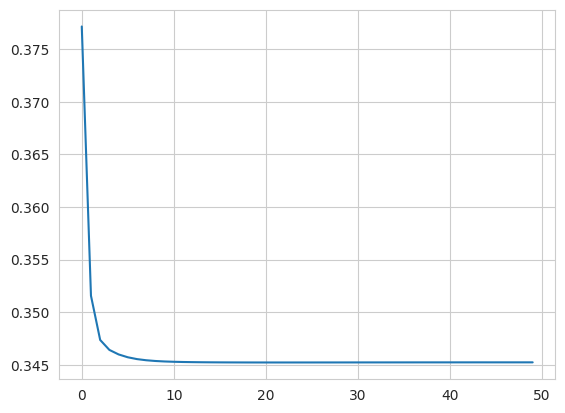

In [19]:
epochs = 50
losses = []
for i in tqdm(range(epochs)):
    l = 0
    for center, context in pairs:
        model.zero_grad()
        prob = model.forward(get_ohe(center, vocab).to(device))
        loss = loss_function(prob, get_ohe(context, vocab).to(device).float())
        loss.backward()
        optimizer.step()        
        l += loss.data.to('cpu')

    losses.append(l/len(pairs))
plt.plot(range(epochs), losses)

As before, the embeddings of nodes are given by the weight parameters in the first layer:

In [32]:
def get_embedding(node, model, vocab):
    return model.embeddings.weight.data[:,vocab.index(node)]

def context_probs(word, vocab, model):
    return { x:p.item() for x,p in zip(vocab, model.forward(get_ohe(word, vocab))[0].detach())}

cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)        

In [33]:
get_embedding('a', model, vocab)

tensor([ 0.3134,  0.8753,  0.5734, -0.6617, -1.5329], device='cuda:0')

In [34]:
context_probs('a', vocab, model)

{'d': 0.10240631550550461,
 'b': 0.5013812184333801,
 'g': 0.0038241371512413025,
 'f': 0.0032222738955169916,
 'e': 0.0011402538511902094,
 'c': 0.2881500720977783,
 'a': 0.09987574070692062}

In [35]:
context_probs('f', vocab, model)

{'d': 0.47085851430892944,
 'b': 0.06740677356719971,
 'g': 0.14472992718219757,
 'f': 0.12090042233467102,
 'e': 0.18441154062747955,
 'c': 0.0052184113301336765,
 'a': 0.006474477704614401}

In [36]:
cos(get_embedding('a', model, vocab), get_embedding('b', model, vocab))

tensor(0.1685, device='cuda:0')

In [37]:
cos(get_embedding('a', model, vocab), get_embedding('f', model, vocab))

tensor(-0.6556, device='cuda:0')

In [38]:
cos(get_embedding('e', model, vocab), get_embedding('f', model, vocab))

tensor(0.4137, device='cuda:0')

In [39]:
svd = TruncatedSVD()
low_dim = svd.fit_transform(np.array([ get_embedding(w, model, vocab).detach().cpu().numpy() for w in vocab]))

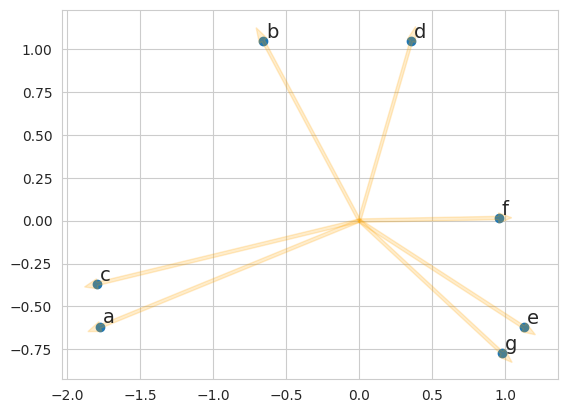

In [40]:
fig, ax = plt.subplots()
ax.scatter(low_dim[:,0], low_dim[:,1])

for i, txt in enumerate(vocab):
    plt.arrow(0, 0, low_dim[i,0], low_dim[i,1], color='orange', width=0.02, alpha=0.2)
    ax.annotate(txt, (low_dim[i,0]+0.02, low_dim[i,1]+0.02), fontsize=14)

## Application to empirical network

In [41]:
karate = pp.io.read_netzschleuder_network('karate', '77')

pp.plot(karate)

In [42]:
rw = pp.processes.RandomWalk(karate)
data = rw.run_experiment(runs=100, steps=5)
walks = rw.get_paths(data)
walks = [[j.item() for j in walks.get_walk(i)] for i in range(walks.num_paths)]

100%|██████████| 100/100 [00:00<00:00, 3909.39it/s]


In [43]:
vocab = build_vocabulary(walks)
pairs = build_word_context_pairs(walks, window_size=2)

In [45]:
model = SkipGram(embedding_dim=5, vocab_size=len(vocab)).to(device)
loss_function = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters())

100%|██████████| 50/50 [01:10<00:00,  1.42s/it]


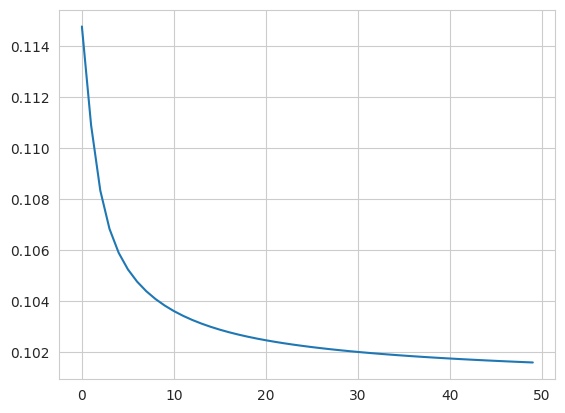

In [47]:
epochs = 50
losses = []
for i in tqdm(range(epochs)):
    l = 0
    for center, context in pairs:
        model.zero_grad()
        prob = model.forward(get_ohe(center, vocab))
        loss = loss_function(prob, get_ohe(context, vocab).float())
        loss.backward()
        optimizer.step()        
        l += loss.data.to('cpu')

    losses.append(l/len(pairs))
plt.plot(range(epochs), losses)

In [48]:
svd = TruncatedSVD()
low_dim = svd.fit_transform(np.array([ get_embedding(w, model, vocab).detach().cpu().numpy() for w in vocab]))

In [49]:
colors = {}
for v in vocab:
    if karate.data.node_groups[v][0] == 1:
        colors[v] = 'orange'
    else:
        colors[v] = 'blue'

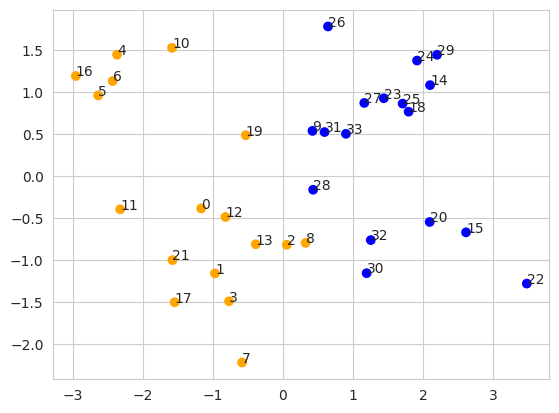

In [50]:
fig, ax = plt.subplots()
ax.scatter(low_dim[:,0], low_dim[:,1], c=[colors[v] for v in vocab])

for i, txt in enumerate(vocab):
    ax.annotate(txt, (low_dim[i,0], low_dim[i,1]))